<a href="https://colab.research.google.com/github/Chuck2Win/-Kaggle-Real-or-Not-NLP-with-Disaster-Tweets/blob/cnn/kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from pandas import DataFrame as df
import nltk
from matplotlib import pyplot as plt
from google.colab import drive
import os

drive.mount('/content/gdrive')
print(os.getcwd()) # current working directory 확인
new_path=('/content/gdrive/My Drive/kaggle')
os.chdir(new_path)
print(os.getcwd())

# file uplaod
# from google.colab import files
# uploaded=files.upload()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/kaggle


In [4]:
data=pd.read_csv('./train.csv',header=0,index_col=0)
print(data.head())
# 1. text data pre processing
# cleanse, tokenize, encoding, vectorize

# 1.1. cleanse
import re
# 이전엔 그냥 str의 replace 활용했는데 #는 못바꾸넹..
# 대문자 -> 소문자
# 특수문자 제거 (구두점, 쉼표 제외)
# http 부분 제거 -> split으로 한 다음에 http 가 있다면 그 부분을 지우고 다시 합치자
def cleanse(sentence):
    result=sentence.lower()
    result=re.sub('[^a-z ,.]','',result)
    result=[i for i in result.split() if 'http' not in i]
    Result=''
    for i in result:
        Result=Result+i+' '
    return Result
data['post_text']=data['text'].apply(lambda i : cleanse(i))
print(data.post_text[:30])
# # of data
len(data) #7613
# train_dev split
from sklearn.model_selection import train_test_split
train_data,val_data=train_test_split(data,test_size=613,shuffle=True) # train data 7000, val da
# nltk로 tokenize
# 1.2. tokenize
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
# train_text_tokenized=word_tokenize(train_data.post_text) #-> error 발생 -> 애초에 word_tokenize는 str을 위한 것

# http가 들어간 sentence들이 있어서 그 부분은 제거해주자.
def word_tokenize_1(sentence):
    j=word_tokenize(sentence)
    result=[i for i in j if 'http' not in i] 
    return result
sentence_tokenized=train_data['post_text'].apply(lambda i : word_tokenize_1(i))
print(sentence_tokenized.head())

   keyword location                                               text  target
id                                                                            
1      NaN      NaN  Our Deeds are the Reason of this #earthquake M...       1
4      NaN      NaN             Forest fire near La Ronge Sask. Canada       1
5      NaN      NaN  All residents asked to 'shelter in place' are ...       1
6      NaN      NaN  13,000 people receive #wildfires evacuation or...       1
7      NaN      NaN  Just got sent this photo from Ruby #Alaska as ...       1
id
1     our deeds are the reason of this earthquake ma...
4               forest fire near la ronge sask. canada 
5     all residents asked to shelter in place are be...
6     , people receive wildfires evacuation orders i...
7     just got sent this photo from ruby alaska as s...
8     rockyfire update california hwy. closed in bot...
10    flood disaster heavy rain causes flash floodin...
13    im on top of the hill and i can see a fire in 

In [0]:
# 1 preprocessing
# torchtext를 활용하면 한방에(tokenize,wordembedding,padding ...)
# SOS,EOS,padding,fix_len : 40 (애초에 twitter는 글자수 제한이 280)
import torchtext
# Field 정의
# Text <- padding 하지 말아라
Text=torchtext.data.Field(sequential=True,use_vocab=True,tokenize=word_tokenize_1,batch_first=True,lower=True,fix_length=None,)
Target=torchtext.data.Field(sequential=False,use_vocab=False,batch_first=True,is_target=True)
Id=torchtext.data.Field(sequential=False,use_vocab=False,batch_first=True)

# Data 정의
# 영어와 ., 만을 남긴 csv 형태로 넘겨주자
# 또한 http부분을 제거
train_data[['post_text','target']].to_csv('train_data.csv',index=True)
train_data_1=torchtext.data.TabularDataset('./train_data.csv',format='csv',fields=[('id',Id),('text',Text),('target',Target)],
                                           skip_header=True)

In [0]:
from gensim.models import Word2Vec
# https://datascience.stackexchange.com/questions/10695/how-to-initialize-a-new-word2vec-model-with-pre-trained-model-weights
# pretrained model을 활용하는데
# 하고자 하는 수순
# 1. 일단 model을 구축한다(train은 하지 말고, 일단 vocab만 만들어 둔다)
# 2. pretrained model을 가져와서 기존의 model과 intersect를 진행 (기존 model의 vocab만 활용, 그리고 pretrained model의 weight만 활용)
# 3. model 학습

#1
model = Word2Vec(size=300,window=3,min_count=3)
model.build_vocab(sentence_tokenized)
print(len(model.wv.vocab)) # 4107

#2
model.intersect_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)
print(len(model.wv.vocab))

print(model.wv.most_similar('disaster'))
print(model.wv.vectors.shape)

#3
# If sentences is the same corpus that was provided to build_vocab() earlier, 
# you can simply use total_examples=self.corpus_count.
model.train(sentence_tokenized,total_examples=model.corpus_count,epochs=500)
print(model.wv.most_similar('disaster'))
print(model.wv.vectors.shape)

4107


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


4107
[('disasters', 0.7751655578613281), ('calamity', 0.7409837245941162), ('catastrophe', 0.7316238880157471), ('tragedy', 0.5871202945709229), ('devastation', 0.5772955417633057), ('earthquake', 0.5394471883773804), ('tsunami', 0.5323168635368347), ('floods', 0.5304961204528809), ('catastrophic', 0.5219818353652954), ('flood', 0.5129648447036743)]
(4107, 300)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('disasters', 0.7751655578613281), ('calamity', 0.7409837245941162), ('catastrophe', 0.7316238880157471), ('tragedy', 0.5871202945709229), ('devastation', 0.5772955417633057), ('earthquake', 0.5394471883773804), ('tsunami', 0.5323168635368347), ('floods', 0.5304961204528809), ('catastrophic', 0.5219818353652954), ('flood', 0.5129648447036743)]
(4107, 300)


In [0]:
# torchtext로 구성해낸다.
# 관건 align 작업
model.wv.save_word2vec_format('./wv')
vectors=torchtext.vocab.Vectors('wv',cache='./') #'./wv'모델을 읽어온다.
# 안될 때엔 변수 싹 다 지우고 다시 해라...

In [0]:
# load embeddings using torchtext
Text.build_vocab(train_data_1,min_freq=3,vectors=vectors)

In [0]:
# 다 같은 것을 입증.
# freq가 달라도, vectors에 있던 것만 들어가게 된다.
result=[]
for vocab,_ in vectors.stoi.items():
    r=vectors.vectors[_]==Text.vocab.vectors[Text.vocab.stoi[vocab]]
    result.append(np.all(r.numpy()))
print(np.all(np.array(result)))

True


In [0]:
batch_size=256
train_loader=torchtext.data.Iterator(train_data_1,batch_size=batch_size)
batch=next(iter(train_loader))

In [0]:
def for_sign(input):
    # input <- tensor, array 등
    # 부호 즉 -1, 1 만을 내뱉는다. 같은 shape로
    input=input.to('cpu')
    result=torch.where(input>0,torch.LongTensor([1]),torch.LongTensor([-1]))
    result[torch.where(input==0)]=0
    return result.to(device)

In [0]:
class cnn_sentiment(nn.Module):
    def __init__(self,num_of_filter,s=3):
        super().__init__()
        self.embedd=nn.Embedding(Text.vocab.vectors.shape[0],Text.vocab.vectors.shape[1],padding_idx=1).from_pretrained(Text.vocab.vectors)
        self.conv1=nn.Sequential(nn.Conv1d(Text.vocab.vectors.shape[1],num_of_filter,2,1),nn.ReLU())
        self.conv2=nn.Sequential(nn.Conv1d(Text.vocab.vectors.shape[1],num_of_filter,3,1),nn.ReLU())
        self.conv3=nn.Sequential(nn.Conv1d(Text.vocab.vectors.shape[1],num_of_filter,4,1),nn.ReLU())
        self.fc=nn.Sequential(nn.Linear(3*num_of_filter,2),nn.ReLU())
        self.s=s
    def forward(self,input):
        x=self.embedd(input) # x shape : [n,seq_len,embedding_dim]
        x1=self.conv1(x.transpose(1,2)) # input shape in here : [n,embedding_dim,seq_len] 
        x2=self.conv2(x.transpose(1,2))
        x3=self.conv3(x.transpose(1,2)) # output shape: [n,num_of_filter,(seq_len-h)+1]
        m1=x1.max(dim=-1)[0]
        m2=x2.max(dim=-1)[0]
        m3=x3.max(dim=-1)[0] # output shape : [n,num_filter]
        X=torch.cat([m1,m2,m3],1) # output shape : [n,num_of_filter*3]
        # weight의 element**2가 3보다 크면, 그냥 3으로 둔다.
        self.fc[0].weight.data[self.fc[0].weight.data**2>self.s]=for_sign(self.fc[0].weight.data[self.fc[0].weight.data**2>self.s])*np.sqrt(self.s)
        result=self.fc(X)
        return result
        

In [0]:
class gru_sentiment(nn.Module):
    def __init__(self,s=3):
        super().__init__()
        self.embedd=nn.Embedding(Text.vocab.vectors.shape[0],Text.vocab.vectors.shape[1],padding_idx=1).from_pretrained(Text.vocab.vectors)
        self.gru=nn.GRU(Text.vocab.vectors.shape[1],Text.vocab.vectors.shape[1],batch_first=True,bidirectional=True) # input : n,seq_len,embedding_dim -> # output : n,seq_len,2*embedding_dim
        self.fc=nn.Sequential(nn.Linear(2*Text.vocab.vectors.shape[1],2),nn.ReLU())
        self.s=s
    def forward(self,input):
        x=self.embedd(input) # x shape : [n,seq_len,embedding_dim]
        x,_=self.gru(x) # x shape : n,seq_len,2*embedding_dim
        # weight의 element**2가 3보다 크면, 그냥 3으로 둔다.
        self.fc[0].weight.data[self.fc[0].weight.data**2>self.s]=for_sign(self.fc[0].weight.data[self.fc[0].weight.data**2>self.s])*np.sqrt(self.s)
        x=x.mean(dim=1)
        result=self.fc(x)
        return result
        

In [21]:
# 학습을 시켜보자
epochs=100
device='cuda' if torch.cuda.is_available else 'cpu'
cost=[]
acc=[]
models=cnn_sentiment(100).to(device)
optimizer=torch.optim.Adam(models.parameters(),0.001)
for epoch in range(epochs):
    if epoch%10==0:
        print(epoch)
    avg_cost=0
    avg_acc=0
    n=0
    for wow in train_loader:
        x=wow.text.to(device)
        y=wow.target.to(device)
        optimizer.zero_grad()
        predict=models.forward(x)
        loss=F.cross_entropy(predict,y)
        ac=(predict.argmax(dim=1)==y).float().mean()
        avg_cost+=loss.item()
        avg_acc+=ac
        n+=1
        loss.backward()
        optimizer.step()
    avg_cost/=n
    avg_acc/=n
    cost.append(avg_cost)
    acc.append(avg_acc)


0
10
20
30
40
50
60
70
80
90


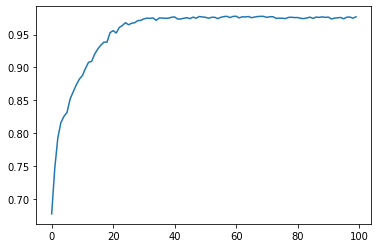

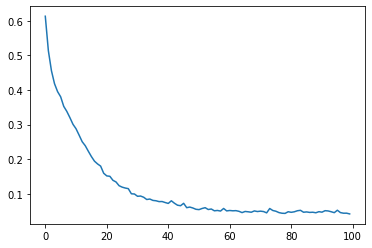

In [23]:
plt.plot(acc,label='acc')
plt.show()
plt.plot(cost,label='cost')
plt.show()

0
10
20
30
40
50
60
70
80
90


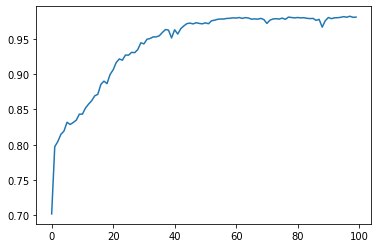

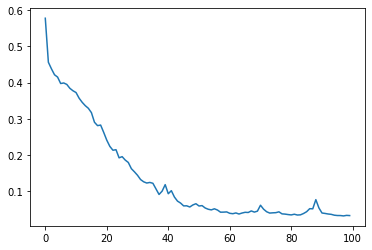

In [42]:
# 학습을 시켜보자
epochs=100
device='cuda' if torch.cuda.is_available else 'cpu'
cost=[]
acc=[]
models=gru_sentiment().to(device)
optimizer=torch.optim.Adam(models.parameters(),0.001)
for epoch in range(epochs):
    if epoch%10==0:
        print(epoch)
    avg_cost=0
    avg_acc=0
    n=0
    for wow in train_loader:
        x=wow.text.to(device)
        y=wow.target.to(device)
        optimizer.zero_grad()
        predict=models.forward(x)
        loss=F.cross_entropy(predict,y)
        ac=(predict.argmax(dim=1)==y).float().mean()
        avg_cost+=loss.item()
        avg_acc+=ac
        n+=1
        loss.backward()
        optimizer.step()
    avg_cost/=n
    avg_acc/=n
    cost.append(avg_cost)
    acc.append(avg_acc)
plt.plot(acc,label='acc')
plt.show()
plt.plot(cost,label='cost')
plt.show()